In [179]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score, roc_curve, auc, precision_recall_curve, plot_precision_recall_curve, classification_report
from sklearn import model_selection

# Catboosting

In [180]:
# Load the data
df = pd.read_csv('../Data/train_format1.csv')
# df_test = pd.read_csv('../Data/test_format1.csv')
user_info = pd.read_csv('../Data/user_info_format1.csv')
user_log = pd.read_csv('../Data/user_log_format1.csv')

# 1. Data Wangling

In [181]:
# Print the shapes
print(df.shape)
print(user_info.shape)
print(user_log.shape)

(260864, 3)
(424170, 3)
(54925330, 7)


### 1.1 df

**df contains the infomation that whether a specific customer will make at least one puchase at a specific merchant whinin 6 months after a big promotion event, showing the result in the label column with '0' as 'False' and '1' as 'True'.**

In [182]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260864 entries, 0 to 260863
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype
---  ------       --------------   -----
 0   user_id      260864 non-null  int64
 1   merchant_id  260864 non-null  int64
 2   label        260864 non-null  int64
dtypes: int64(3)
memory usage: 6.0 MB


In [183]:
df.head()

,user_id,merchant_id,label
0,34176,3906,0
1,34176,121,0
2,34176,4356,1
3,34176,2217,0
4,230784,4818,0


In [184]:
# label values indicates an around 15:1 ratio between non-repeated customers and repeated ones, which is highly imbalanced.
df.label.value_counts()

0    244912
1     15952
Name: label, dtype: int64

### 1.2 user_info

**User_info contains the infomation about the customers. For instance, 'age_range column' classifies the customers' ages as such: 1 for <18; 2 for 18-24; 3 for 25-29; 4 for 30-34; 5 for 35-39; 6 for 40-49; 7 and 8 for >= 50; and
0 and NULL for unknown. Moreover, 'gender' column classifies 0 for female, 1 for male, 2 and NULL for unknown.**

In [185]:
# Info on User's infomation data
user_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424170 entries, 0 to 424169
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   user_id    424170 non-null  int64  
 1   age_range  421953 non-null  float64
 2   gender     417734 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 9.7 MB


In [186]:
# Head of User's infomation data
user_info.head(10)

,user_id,age_range,gender
0,376517,6.0,1.0
1,234512,5.0,0.0
2,344532,5.0,0.0
3,186135,5.0,0.0
4,30230,5.0,0.0
5,272389,6.0,1.0
6,281071,4.0,0.0
7,139859,7.0,0.0
8,198411,5.0,1.0
9,67037,4.0,1.0


In [187]:
# Confirm the missing value size
user_info.isnull().sum(axis=0)

user_id         0
age_range    2217
gender       6436
dtype: int64

In [188]:
# Fill the missing values with 'unknown' string.
user_info = user_info.fillna(value={'age_range':'unknown', 'gender':'unknown'})
user_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424170 entries, 0 to 424169
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    424170 non-null  int64 
 1   age_range  424170 non-null  object
 2   gender     424170 non-null  object
dtypes: int64(1), object(2)
memory usage: 9.7+ MB


In [189]:
# Value counts on ages
user_info.value_counts('age_range')

age_range
3.0        111654
0.0         92914
4.0         79991
2.0         52871
5.0         40777
6.0         35464
7.0          6992
unknown      2217
8.0          1266
1.0            24
dtype: int64

In [190]:
# Value counts on gender
user_info.value_counts('gender')

gender
0.0        285638
1.0        121670
2.0         10426
unknown      6436
dtype: int64

In [191]:
# Replace numerical values with stings
user_info['age_range'].replace({0.0:'unknown', 1.0:'<18', 2.0:'18-24', 3.0:'25-29', 4.0:'30-34', 5.0:'35-39', 6.0:'40-49', 7.0:'>=50', 8.0:'>=50'},inplace=True)
user_info['gender'].replace({0.0:'female', 1.0:'male', 2.0:'unknown'},inplace=True)
user_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424170 entries, 0 to 424169
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    424170 non-null  int64 
 1   age_range  424170 non-null  object
 2   gender     424170 non-null  object
dtypes: int64(1), object(2)
memory usage: 9.7+ MB


In [192]:
user_info.head()

,user_id,age_range,gender
0,376517,40-49,male
1,234512,35-39,female
2,344532,35-39,female
3,186135,35-39,female
4,30230,35-39,female


### 1.3 user_log

**User_log contains the infomation as below:**
* user_id: a unique id for the customer.
* item_id: a unique id for the item.
* cat_id: a unique id for the category that the item belongs to.
* merchant_id: a unique id for the merchant.
* brand_id: a unique id for the brand of the item.
* time_tamp: date the action took place (format: mmdd)
* action_type: customers' actions, where 0 for click, 1 for add-to-cart, 2 for purchase and 3 for add-to-favourite.


In [193]:
user_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54925330 entries, 0 to 54925329
Data columns (total 7 columns):
 #   Column       Dtype  
---  ------       -----  
 0   user_id      int64  
 1   item_id      int64  
 2   cat_id       int64  
 3   seller_id    int64  
 4   brand_id     float64
 5   time_stamp   int64  
 6   action_type  int64  
dtypes: float64(1), int64(6)
memory usage: 2.9 GB


In [194]:
user_log.head()

,user_id,item_id,cat_id,seller_id,brand_id,time_stamp,action_type
0,328862,323294,833,2882,2661.0,829,0
1,328862,844400,1271,2882,2661.0,829,0
2,328862,575153,1271,2882,2661.0,829,0
3,328862,996875,1271,2882,2661.0,829,0
4,328862,1086186,1271,1253,1049.0,829,0


In [195]:
user_log.action_type.value_counts()

0    48550713
2     3292144
3     3005723
1       76750
Name: action_type, dtype: int64

In [196]:
# check missing values
user_log.isnull().sum(axis=0)

user_id            0
item_id            0
cat_id             0
seller_id          0
brand_id       91015
time_stamp         0
action_type        0
dtype: int64

**Only about 0.15% values in brand_id are missing. In general, these missing values could be dropped entirely. Nevertheless, we will keep it for now and reconsider it after completing the feature creations.**

# 2. EDA part 1

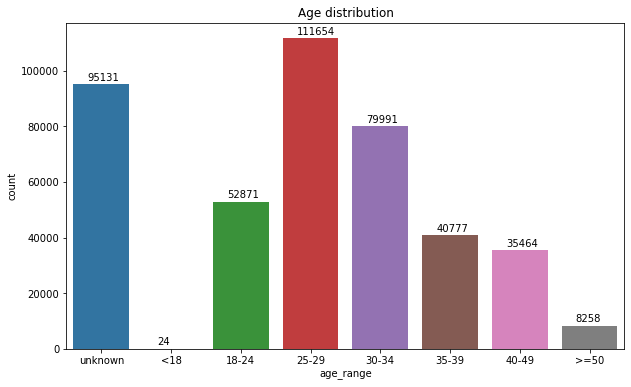

In [197]:
# plot the customer distribution by age groups
fig = plt.figure(figsize = (10, 6))
ax = sns.countplot(x='age_range', order=['unknown', '<18', '18-24', '25-29', '30-34', '35-39', '40-49', '>=50'], data = user_info)
plt.title('Age distribution')
for p in ax.patches:
        ax.annotate(p.get_height(), (p.get_x()+0.2, p.get_height()+1500))

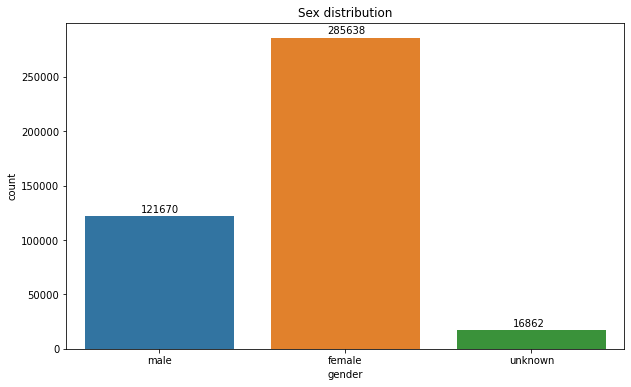

In [198]:
# plot the customer distribution by sex groups
fig = plt.figure(figsize = (10, 6))
ax = sns.countplot(x='gender', data = user_info)
plt.title('Sex distribution')
for p in ax.patches:
        ax.annotate(p.get_height(), (p.get_x()+0.3, p.get_height()+4000))

Text(0.5, 1.0, 'Age and Sex distribution')

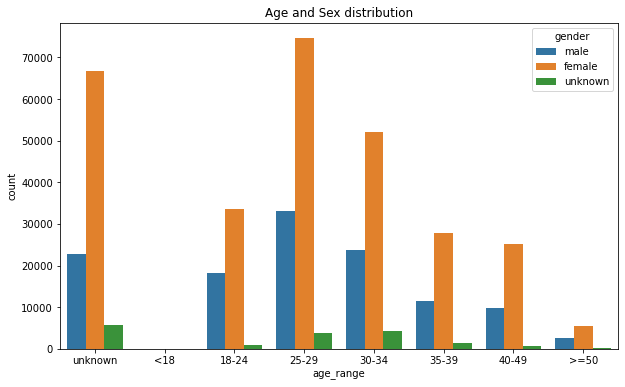

In [199]:
# plot the customer distribution by age and sex groups
fig = plt.figure(figsize = (10, 6))
sns.countplot(x='age_range', order=['unknown', '<18', '18-24', '25-29', '30-34', '35-39', '40-49', '>=50'], hue= 'gender',data = user_info)
plt.title('Age and Sex distribution')

**Most customers are aged between 18 - 34, and much more female customers than male.**

In [200]:
user_log.time_stamp.value_counts()

1111    10582633
1110     2940826
1109     1207273
1108      968099
1107      857846
          ...   
512        20704
511        20044
518        19243
519        18430
1112          46
Name: time_stamp, Length: 186, dtype: int64

<AxesSubplot:>

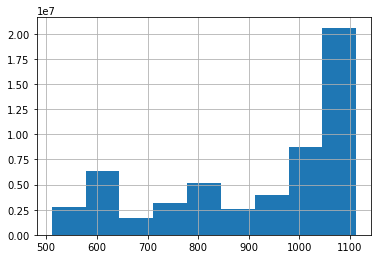

In [201]:
# plot the time_stamp
user_log['time_stamp'].hist(bins = 9)

**Most recorded customer activities occur around Nov.11 (China's Double 11 shopping festival) and Jun.18 (China's 618 shopping event).**

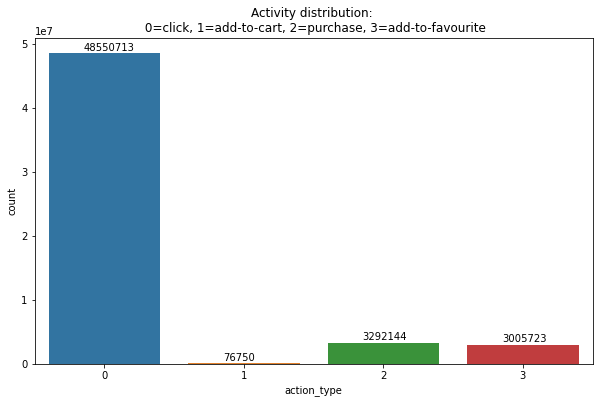

In [202]:
# plot the customer distribution by sex groups
fig = plt.figure(figsize = (10, 6))
ax = sns.countplot(x = 'action_type', order = [0,1,2,3],data = user_log)
plt.title('Activity distribution: \n 0=click, 1=add-to-cart, 2=purchase, 3=add-to-favourite')
for p in ax.patches:
        ax.annotate(p.get_height(), (p.get_x()+0.25, p.get_height()+500000))

In [203]:
user_log.action_type.value_counts(normalize=True)

0    0.883940
2    0.059939
3    0.054724
1    0.001397
Name: action_type, dtype: float64

**88.4% activities are "click" on the product page, while 6.0% are "purchase" and 5.5% are "add to favourite". Only about 0.1% activities are "add to cart"**

# 3. Pre-processing

In [204]:
df.head()

,user_id,merchant_id,label
0,34176,3906,0
1,34176,121,0
2,34176,4356,1
3,34176,2217,0
4,230784,4818,0


In [205]:
user_info.head()

,user_id,age_range,gender
0,376517,40-49,male
1,234512,35-39,female
2,344532,35-39,female
3,186135,35-39,female
4,30230,35-39,female


In [206]:
user_log.head()

,user_id,item_id,cat_id,seller_id,brand_id,time_stamp,action_type
0,328862,323294,833,2882,2661.0,829,0
1,328862,844400,1271,2882,2661.0,829,0
2,328862,575153,1271,2882,2661.0,829,0
3,328862,996875,1271,2882,2661.0,829,0
4,328862,1086186,1271,1253,1049.0,829,0


In [207]:
# check the activities of the first user at the first merchant
user_log[(user_log['user_id'] == 34176) & (user_log['seller_id'] == 3906)]

,user_id,item_id,cat_id,seller_id,brand_id,time_stamp,action_type
35905644,34176,757713,821,3906,6268.0,1110,0
35905646,34176,757713,821,3906,6268.0,1110,0
35905672,34176,757713,821,3906,6268.0,1110,0
35905696,34176,718096,1142,3906,6268.0,1031,3
35905720,34176,757713,821,3906,6268.0,1031,3
35905791,34176,613698,821,3906,6268.0,1021,0
35905804,34176,757713,821,3906,6268.0,1108,0
35905824,34176,757713,821,3906,6268.0,1029,0
35905830,34176,1093165,1397,3906,6268.0,1027,0
35905831,34176,898580,662,3906,6268.0,1027,0


**We need to extract and create useful features from user_info and user_log and put it together into df in order to build and train the model.**

**List of features needed are:**
* age_range: customers' age
* gender: customers' sex
* total_logs: number of recorded activities of customer at given merchant
* diff_item_review: number of different product/item reviewed by customer at given merchant
* diff_cat_review: number of different categories of product/item reviewed by customer at given merchant
* browse_days: number of days with activities
* one_clicks: number of clicks
* shopping_carts: number of "add to cart"
* purchase_times: number of puchases
* favourite_times: number of "add to favourite"

In [208]:
# add age_range and gender to df
df = pd.merge(df,user_info,on="user_id",how="left")
df.head()

,user_id,merchant_id,label,age_range,gender
0,34176,3906,0,40-49,female
1,34176,121,0,40-49,female
2,34176,4356,1,40-49,female
3,34176,2217,0,40-49,female
4,230784,4818,0,unknown,female


In [209]:
# create total_logs
total_logs_temp = user_log.groupby([user_log["user_id"],user_log["seller_id"]]).count().reset_index()[["user_id","seller_id","item_id"]]
total_logs_temp.head()

,user_id,seller_id,item_id
0,1,471,1
1,1,739,1
2,1,925,4
3,1,1019,14
4,1,1156,1


In [210]:
total_logs_temp.rename(columns={"seller_id":"merchant_id","item_id":"total_logs"},inplace=True)
total_logs_temp.head()

,user_id,merchant_id,total_logs
0,1,471,1
1,1,739,1
2,1,925,4
3,1,1019,14
4,1,1156,1


In [211]:
# add total_logs
df = pd.merge(df, total_logs_temp, on=["user_id","merchant_id"],how="left")
df.head()

,user_id,merchant_id,label,age_range,gender,total_logs
0,34176,3906,0,40-49,female,39
1,34176,121,0,40-49,female,14
2,34176,4356,1,40-49,female,18
3,34176,2217,0,40-49,female,2
4,230784,4818,0,unknown,female,8


In [212]:
# create diff_item_review
diff_item_review_temp = user_log.groupby([user_log["user_id"],user_log["seller_id"],user_log["item_id"]]).count().reset_index()[["user_id","seller_id","item_id"]]
diff_item_review_temp.head()

,user_id,seller_id,item_id
0,1,471,638653
1,1,739,556107
2,1,925,504149
3,1,1019,1110495
4,1,1156,896183


In [213]:
diff_item_review_temp1 = diff_item_review_temp.groupby([diff_item_review_temp["user_id"],diff_item_review_temp["seller_id"]]).count().reset_index()
diff_item_review_temp1.head()

,user_id,seller_id,item_id
0,1,471,1
1,1,739,1
2,1,925,1
3,1,1019,1
4,1,1156,1


In [214]:
diff_item_review_temp1.rename(columns={"seller_id":"merchant_id","item_id":"diff_item_review"},inplace=True)
diff_item_review_temp1.head()

,user_id,merchant_id,diff_item_review
0,1,471,1
1,1,739,1
2,1,925,1
3,1,1019,1
4,1,1156,1


In [215]:
# add diff_item_review
df = pd.merge(df,diff_item_review_temp1,on=["user_id","merchant_id"],how="left")
df.head()

,user_id,merchant_id,label,age_range,gender,total_logs,diff_item_review
0,34176,3906,0,40-49,female,39,20
1,34176,121,0,40-49,female,14,1
2,34176,4356,1,40-49,female,18,2
3,34176,2217,0,40-49,female,2,1
4,230784,4818,0,unknown,female,8,1


In [216]:
# create diff_cat_review
diff_cat_review_temp = user_log.groupby([user_log["user_id"],user_log["seller_id"],user_log["cat_id"]]).count().reset_index()[["user_id","seller_id","cat_id"]]
diff_cat_review_temp.head()

,user_id,seller_id,cat_id
0,1,471,389
1,1,739,1252
2,1,925,1023
3,1,1019,992
4,1,1156,1256


In [217]:
diff_cat_review_temp1 = diff_cat_review_temp.groupby([diff_cat_review_temp["user_id"],diff_cat_review_temp["seller_id"]]).count().reset_index()
diff_cat_review_temp1.head(10)

,user_id,seller_id,cat_id
0,1,471,1
1,1,739,1
2,1,925,1
3,1,1019,1
4,1,1156,1
5,1,2245,1
6,1,4026,1
7,1,4177,1
8,1,4335,1
9,2,420,2


In [218]:
diff_cat_review_temp1.rename(columns={"seller_id":"merchant_id","cat_id":"diff_cat_review"},inplace=True)
diff_cat_review_temp1.head(10)

,user_id,merchant_id,diff_cat_review
0,1,471,1
1,1,739,1
2,1,925,1
3,1,1019,1
4,1,1156,1
5,1,2245,1
6,1,4026,1
7,1,4177,1
8,1,4335,1
9,2,420,2


In [219]:
# add diff_cat_review
df = pd.merge(df,diff_cat_review_temp1,on=["user_id","merchant_id"],how="left")
df.head()

,user_id,merchant_id,label,age_range,gender,total_logs,diff_item_review,diff_cat_review
0,34176,3906,0,40-49,female,39,20,6
1,34176,121,0,40-49,female,14,1,1
2,34176,4356,1,40-49,female,18,2,1
3,34176,2217,0,40-49,female,2,1,1
4,230784,4818,0,unknown,female,8,1,1


In [220]:
# create browse_days
browse_days_temp = user_log.groupby([user_log["user_id"],user_log["seller_id"],user_log["time_stamp"]]).count().reset_index()[["user_id","seller_id","time_stamp"]]
browse_days_temp.head(10)

,user_id,seller_id,time_stamp
0,1,471,1111
1,1,739,1018
2,1,925,1011
3,1,1019,1111
4,1,1156,1111
5,1,2245,1009
6,1,4026,1018
7,1,4026,1021
8,1,4177,1018
9,1,4335,1111


In [221]:
browse_days_temp1 = browse_days_temp.groupby([browse_days_temp["user_id"],browse_days_temp["seller_id"]]).count().reset_index()
browse_days_temp1.head(10)

,user_id,seller_id,time_stamp
0,1,471,1
1,1,739,1
2,1,925,1
3,1,1019,1
4,1,1156,1
5,1,2245,1
6,1,4026,2
7,1,4177,1
8,1,4335,1
9,2,420,1


In [222]:
browse_days_temp1.rename(columns={"seller_id":"merchant_id","time_stamp":"browse_days"},inplace=True)
browse_days_temp1.head(10)

,user_id,merchant_id,browse_days
0,1,471,1
1,1,739,1
2,1,925,1
3,1,1019,1
4,1,1156,1
5,1,2245,1
6,1,4026,2
7,1,4177,1
8,1,4335,1
9,2,420,1


In [223]:
# add browse_days
df = pd.merge(df,browse_days_temp1,on=["user_id","merchant_id"],how="left")
df.head()

,user_id,merchant_id,label,age_range,gender,total_logs,diff_item_review,diff_cat_review,browse_days
0,34176,3906,0,40-49,female,39,20,6,9
1,34176,121,0,40-49,female,14,1,1,3
2,34176,4356,1,40-49,female,18,2,1,2
3,34176,2217,0,40-49,female,2,1,1,1
4,230784,4818,0,unknown,female,8,1,1,3


In [224]:
# create one_clicks
one_clicks_temp = user_log.groupby([user_log["user_id"],user_log["seller_id"],user_log["action_type"]]).count().reset_index()[["user_id","seller_id","action_type","item_id"]]
one_clicks_temp.head()

,user_id,seller_id,action_type,item_id
0,1,471,0,1
1,1,739,0,1
2,1,925,0,3
3,1,925,2,1
4,1,1019,0,10


In [225]:
one_clicks_temp.rename(columns={"seller_id":"merchant_id","item_id":"times"},inplace=True)
one_clicks_temp.head(10)

,user_id,merchant_id,action_type,times
0,1,471,0,1
1,1,739,0,1
2,1,925,0,3
3,1,925,2,1
4,1,1019,0,10
5,1,1019,2,4
6,1,1156,0,1
7,1,2245,0,5
8,1,4026,0,4
9,1,4026,2,1


In [226]:
one_clicks_temp["one_clicks"] = one_clicks_temp["action_type"] == 0
one_clicks_temp["one_clicks"] = one_clicks_temp["one_clicks"] * one_clicks_temp["times"]
one_clicks_temp.head(10)

,user_id,merchant_id,action_type,times,one_clicks
0,1,471,0,1,1
1,1,739,0,1,1
2,1,925,0,3,3
3,1,925,2,1,0
4,1,1019,0,10,10
5,1,1019,2,4,0
6,1,1156,0,1,1
7,1,2245,0,5,5
8,1,4026,0,4,4
9,1,4026,2,1,0


In [227]:
# create shopping_carts
one_clicks_temp["shopping_carts"] = one_clicks_temp["action_type"] == 1
one_clicks_temp["shopping_carts"] = one_clicks_temp["shopping_carts"] * one_clicks_temp["times"]
one_clicks_temp.head(10)

,user_id,merchant_id,action_type,times,one_clicks,shopping_carts
0,1,471,0,1,1,0
1,1,739,0,1,1,0
2,1,925,0,3,3,0
3,1,925,2,1,0,0
4,1,1019,0,10,10,0
5,1,1019,2,4,0,0
6,1,1156,0,1,1,0
7,1,2245,0,5,5,0
8,1,4026,0,4,4,0
9,1,4026,2,1,0,0


In [228]:
# create purchase_times
one_clicks_temp["purchase_times"] = one_clicks_temp["action_type"] == 2
one_clicks_temp["purchase_times"] = one_clicks_temp["purchase_times"] * one_clicks_temp["times"]
one_clicks_temp.head(10)

,user_id,merchant_id,action_type,times,one_clicks,shopping_carts,purchase_times
0,1,471,0,1,1,0,0
1,1,739,0,1,1,0,0
2,1,925,0,3,3,0,0
3,1,925,2,1,0,0,1
4,1,1019,0,10,10,0,0
5,1,1019,2,4,0,0,4
6,1,1156,0,1,1,0,0
7,1,2245,0,5,5,0,0
8,1,4026,0,4,4,0,0
9,1,4026,2,1,0,0,1


In [229]:
# create favourite_times
one_clicks_temp["favourite_times"] = one_clicks_temp["action_type"] == 3
one_clicks_temp["favourite_times"] = one_clicks_temp["favourite_times"] * one_clicks_temp["times"]
one_clicks_temp.head(10)

,user_id,merchant_id,action_type,times,one_clicks,shopping_carts,purchase_times,favourite_times
0,1,471,0,1,1,0,0,0
1,1,739,0,1,1,0,0,0
2,1,925,0,3,3,0,0,0
3,1,925,2,1,0,0,1,0
4,1,1019,0,10,10,0,0,0
5,1,1019,2,4,0,0,4,0
6,1,1156,0,1,1,0,0,0
7,1,2245,0,5,5,0,0,0
8,1,4026,0,4,4,0,0,0
9,1,4026,2,1,0,0,1,0


In [230]:
four_features = one_clicks_temp.groupby([one_clicks_temp["user_id"],one_clicks_temp["merchant_id"]]).sum().reset_index()
four_features.head(10)

,user_id,merchant_id,action_type,times,one_clicks,shopping_carts,purchase_times,favourite_times
0,1,471,0,1,1,0,0,0
1,1,739,0,1,1,0,0,0
2,1,925,2,4,3,0,1,0
3,1,1019,2,14,10,0,4,0
4,1,1156,0,1,1,0,0,0
5,1,2245,0,5,5,0,0,0
6,1,4026,2,5,4,0,1,0
7,1,4177,0,1,1,0,0,0
8,1,4335,0,1,1,0,0,0
9,2,420,2,26,23,0,3,0


In [231]:
# add one_clicks, shopping_carts, purchase_times, and favourite_times
four_features = four_features.drop(["action_type","times"], axis=1)
df = pd.merge(df,four_features,on=["user_id","merchant_id"],how="left")
df.head()

,user_id,merchant_id,label,age_range,gender,total_logs,diff_item_review,diff_cat_review,browse_days,one_clicks,shopping_carts,purchase_times,favourite_times
0,34176,3906,0,40-49,female,39,20,6,9,36,0,1,2
1,34176,121,0,40-49,female,14,1,1,3,13,0,1,0
2,34176,4356,1,40-49,female,18,2,1,2,12,0,6,0
3,34176,2217,0,40-49,female,2,1,1,1,1,0,1,0
4,230784,4818,0,unknown,female,8,1,1,3,7,0,1,0


In [232]:
# check the info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260864 entries, 0 to 260863
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   user_id           260864 non-null  int64 
 1   merchant_id       260864 non-null  int64 
 2   label             260864 non-null  int64 
 3   age_range         260864 non-null  object
 4   gender            260864 non-null  object
 5   total_logs        260864 non-null  int64 
 6   diff_item_review  260864 non-null  int64 
 7   diff_cat_review   260864 non-null  int64 
 8   browse_days       260864 non-null  int64 
 9   one_clicks        260864 non-null  int64 
 10  shopping_carts    260864 non-null  int64 
 11  purchase_times    260864 non-null  int64 
 12  favourite_times   260864 non-null  int64 
dtypes: int64(11), object(2)
memory usage: 27.9+ MB


In [233]:
# no missing values
df.isnull().sum(axis=0)

user_id             0
merchant_id         0
label               0
age_range           0
gender              0
total_logs          0
diff_item_review    0
diff_cat_review     0
browse_days         0
one_clicks          0
shopping_carts      0
purchase_times      0
favourite_times     0
dtype: int64

In [234]:
# one-hot encoding for categorical features: age_range, gender
df = pd.get_dummies(df)
df

,user_id,merchant_id,label,total_logs,diff_item_review,diff_cat_review,browse_days,one_clicks,shopping_carts,purchase_times,...,age_range_25-29,age_range_30-34,age_range_35-39,age_range_40-49,age_range_<18,age_range_>=50,age_range_unknown,gender_female,gender_male,gender_unknown
0,34176,3906,0,39,20,6,9,36,0,1,...,0,0,0,1,0,0,0,1,0,0
1,34176,121,0,14,1,1,3,13,0,1,...,0,0,0,1,0,0,0,1,0,0
2,34176,4356,1,18,2,1,2,12,0,6,...,0,0,0,1,0,0,0,1,0,0
3,34176,2217,0,2,1,1,1,1,0,1,...,0,0,0,1,0,0,0,1,0,0
4,230784,4818,0,8,1,1,3,7,0,1,...,0,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260859,359807,4325,0,20,6,2,1,18,0,2,...,0,1,0,0,0,0,0,0,1,0
260860,294527,3971,0,17,3,1,2,13,0,1,...,0,0,0,0,0,0,1,0,1,0
260861,294527,152,0,9,1,1,1,7,0,1,...,0,0,0,0,0,0,1,0,1,0
260862,294527,2537,0,1,1,1,1,0,0,1,...,0,0,0,0,0,0,1,0,1,0


**No data scaling needed since all useful features are within similar range (1-100).**

# 4. EDA part 2

In [235]:
# check the column names and make it a list
col = df.columns.tolist()
print(col)

['user_id', 'merchant_id', 'label', 'total_logs', 'diff_item_review', 'diff_cat_review', 'browse_days', 'one_clicks', 'shopping_carts', 'purchase_times', 'favourite_times', 'age_range_18-24', 'age_range_25-29', 'age_range_30-34', 'age_range_35-39', 'age_range_40-49', 'age_range_<18', 'age_range_>=50', 'age_range_unknown', 'gender_female', 'gender_male', 'gender_unknown']


Text(0.5, 1.0, 'number of customers by total_logs')

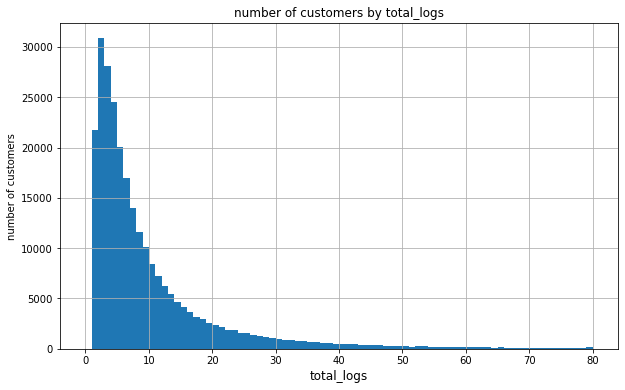

In [236]:
# number of customers by total_logs
fig = plt.figure(figsize=(10,6))
df[col[3]].hist(range=[0,80],bins = 80)
plt.xlabel(col[3],fontsize = 12)
plt.ylabel('number of customers')
plt.title('number of customers by total_logs')

Text(0.5, 1.0, 'number of customers by different items reviewed')

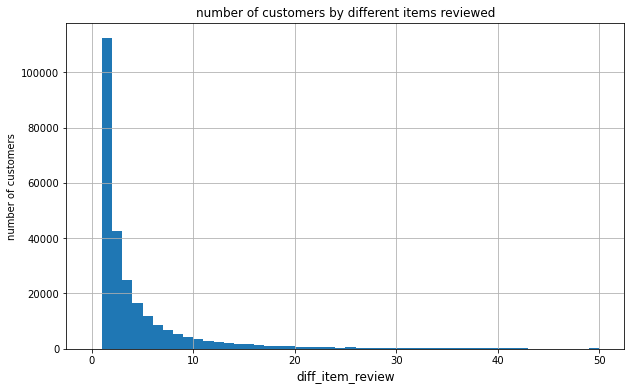

In [237]:
# number of number of customers by different items reviewed
fig = plt.figure(figsize=(10,6))
df[col[4]].hist(range=[0,50],bins = 50)
plt.xlabel(col[4],fontsize = 12)
plt.ylabel('number of customers')
plt.title('number of customers by different items reviewed')

Text(0.5, 1.0, 'number of customers by different categories reviewed')

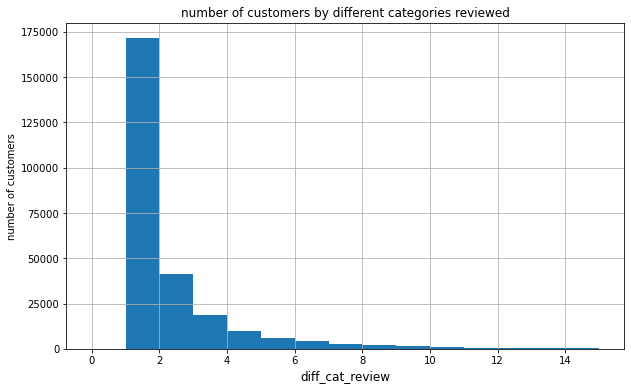

In [238]:
# number of number of customers by different categories reviewed
fig = plt.figure(figsize=(10,6))
df[col[5]].hist(range=[0,15],bins = 15)
plt.xlabel(col[5],fontsize = 12)
plt.ylabel('number of customers')
plt.title('number of customers by different categories reviewed')

Text(0.5, 1.0, 'number of customers by browse days')

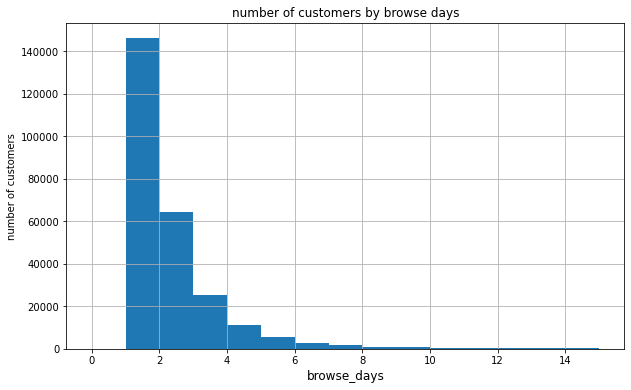

In [239]:
# number of number of customers by browse days
fig = plt.figure(figsize=(10,6))
df[col[6]].hist(range=[0,15],bins = 15)
plt.xlabel(col[6],fontsize = 12)
plt.ylabel('number of customers')
plt.title('number of customers by browse days')

Text(0.5, 1.0, 'number of customers by one clicks')

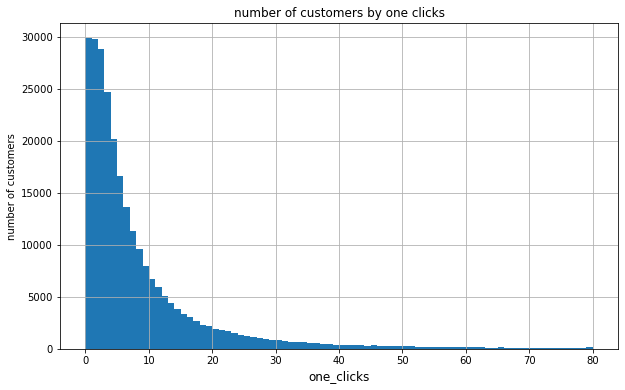

In [240]:
# number of number of customers by one clicks
fig = plt.figure(figsize=(10,6))
df[col[7]].hist(range=[0,80],bins = 80)
plt.xlabel(col[7],fontsize = 12)
plt.ylabel('number of customers')
plt.title('number of customers by one clicks')

Text(0.5, 1.0, 'number of customers by different shopping carts')

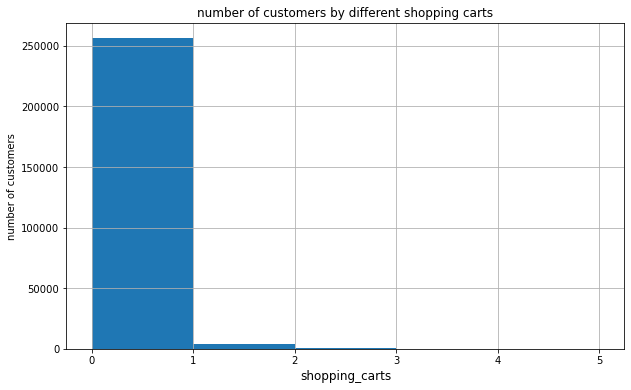

In [241]:
# number of number of customers by shopping carts
fig = plt.figure(figsize=(10,6))
df[col[8]].hist(range=[0,5],bins = 5)
plt.xlabel(col[8],fontsize = 12)
plt.ylabel('number of customers')
plt.title('number of customers by different shopping carts')

Text(0.5, 1.0, 'number of customers by purchases')

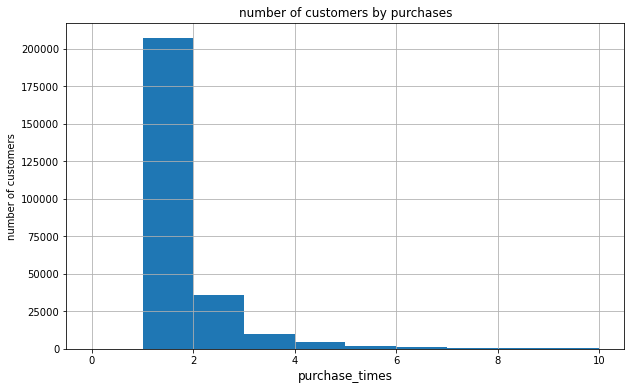

In [242]:
# number of number of customers by puchases
fig = plt.figure(figsize=(10,6))
df[col[9]].hist(range=[0,10],bins = 10)
plt.xlabel(col[9],fontsize = 12)
plt.ylabel('number of customers')
plt.title('number of customers by purchases')

Text(0.5, 1.0, 'number of customers by favourite times')

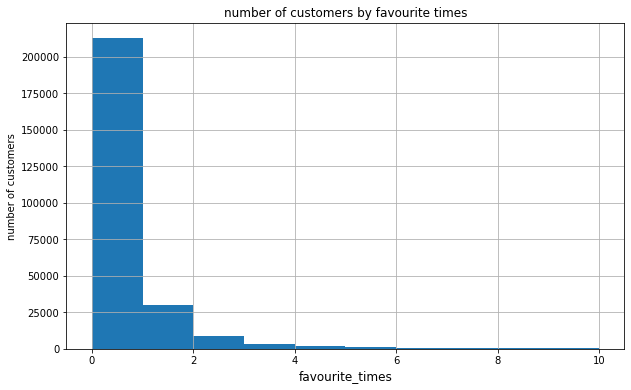

In [243]:
# number of number of customers by favourite times
fig = plt.figure(figsize=(10,6))
df[col[10]].hist(range=[0,10],bins = 10)
plt.xlabel(col[10],fontsize = 12)
plt.ylabel('number of customers')
plt.title('number of customers by favourite times')

In [244]:
# correlation
corr = df.drop(['user_id','merchant_id'],axis=1).corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,label,total_logs,diff_item_review,diff_cat_review,browse_days,one_clicks,shopping_carts,purchase_times,favourite_times,age_range_18-24,age_range_25-29,age_range_30-34,age_range_35-39,age_range_40-49,age_range_<18,age_range_>=50,age_range_unknown,gender_female,gender_male,gender_unknown
label,1.00,0.08,0.10,0.10,0.08,0.08,-0.00,0.08,0.05,-0.02,-0.01,0.01,0.01,0.01,-0.00,0.00,-0.01,0.02,-0.02,-0.00
total_logs,0.08,1.00,0.80,0.59,0.54,1.00,0.06,0.29,0.41,-0.01,0.01,0.00,0.01,0.01,0.00,0.01,-0.02,0.04,-0.04,-0.00
diff_item_review,0.10,0.80,1.00,0.75,0.57,0.78,0.05,0.31,0.42,-0.02,0.01,0.01,0.01,0.01,-0.00,-0.00,-0.02,0.06,-0.06,-0.00
diff_cat_review,0.10,0.59,0.75,1.00,0.48,0.57,0.05,0.38,0.34,-0.01,0.02,0.02,0.01,-0.01,-0.00,-0.01,-0.03,0.06,-0.07,0.00
browse_days,0.08,0.54,0.57,0.48,1.00,0.53,0.04,0.09,0.46,-0.00,0.01,-0.00,0.01,0.02,0.00,0.01,-0.02,0.06,-0.06,-0.00
one_clicks,0.08,1.00,0.78,0.57,0.53,1.00,0.05,0.24,0.35,-0.01,0.01,0.00,0.01,0.01,0.00,0.01,-0.02,0.04,-0.04,-0.00
shopping_carts,-0.00,0.06,0.05,0.05,0.04,0.05,1.00,0.00,-0.00,-0.01,-0.01,-0.02,-0.01,-0.00,0.00,0.00,0.04,-0.02,0.01,0.02
purchase_times,0.08,0.29,0.31,0.38,0.09,0.24,0.00,1.00,0.10,-0.04,-0.00,0.04,0.03,0.00,0.00,-0.00,-0.03,0.04,-0.04,0.01
favourite_times,0.05,0.41,0.42,0.34,0.46,0.35,-0.00,0.10,1.00,0.03,0.02,-0.01,-0.01,-0.00,0.00,-0.00,-0.02,0.05,-0.05,-0.00
age_range_18-24,-0.02,-0.01,-0.02,-0.01,-0.00,-0.01,-0.01,-0.04,0.03,1.00,-0.22,-0.18,-0.12,-0.11,-0.00,-0.05,-0.19,-0.03,0.05,-0.05


<AxesSubplot:>

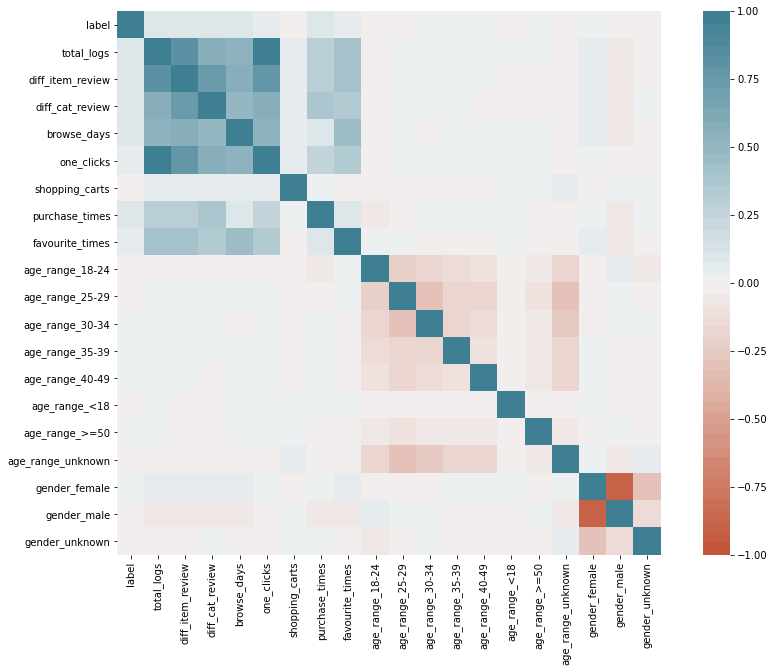

In [245]:
# heatmap
fig = plt.figure(figsize=(15,10))
sns.heatmap(corr, vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20, 220, n=50), square=True)

**No significant correlations between 'label' and other features.**

# 5. Modeling

In [246]:
y = df['label']
X = df.drop(['user_id','merchant_id','label'],axis = 1)
X.head(10)

,total_logs,diff_item_review,diff_cat_review,browse_days,one_clicks,shopping_carts,purchase_times,favourite_times,age_range_18-24,age_range_25-29,age_range_30-34,age_range_35-39,age_range_40-49,age_range_<18,age_range_>=50,age_range_unknown,gender_female,gender_male,gender_unknown
0,39,20,6,9,36,0,1,2,0,0,0,0,1,0,0,0,1,0,0
1,14,1,1,3,13,0,1,0,0,0,0,0,1,0,0,0,1,0,0
2,18,2,1,2,12,0,6,0,0,0,0,0,1,0,0,0,1,0,0
3,2,1,1,1,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0
4,8,1,1,3,7,0,1,0,0,0,0,0,0,0,0,1,1,0,0
5,1,1,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0
6,3,2,1,1,2,0,1,0,0,0,0,1,0,0,0,0,1,0,0
7,83,48,15,3,78,0,5,0,0,0,0,1,0,0,0,0,1,0,0
8,7,4,1,1,6,0,1,0,0,0,0,1,0,0,0,0,1,0,0
9,4,1,1,2,2,0,1,1,0,0,1,0,0,0,0,0,0,1,0


In [247]:
y.head()

0    0
1    0
2    1
3    0
4    0
Name: label, dtype: int64

In [248]:
from imblearn.over_sampling import SMOTE

print("Before OverSampling, counts of label '1': {}".format(sum(y==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y==0)))

sm = SMOTE(random_state=42)
X, y = sm.fit_resample(X, y)

print('After OverSampling, the shape of train_X: {}'.format(X.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y==0)))

Before OverSampling, counts of label '1': 15952
Before OverSampling, counts of label '0': 244912 

After OverSampling, the shape of train_X: (489824, 19)
After OverSampling, the shape of train_y: (489824,) 

After OverSampling, counts of label '1': 244912
After OverSampling, counts of label '0': 244912


In [249]:
# split the training and test data set
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25,random_state = 42)

### 5.1 Logistic Regression

In [250]:
# Logistic regression model fitting
logit = LogisticRegression(solver='liblinear')   #'saga', penalty='l1', max_iter=2000, random_state=42)
logit.fit(X_train, y_train)
y_pred = logit.predict(X_test)
#Predict_proba = logit.predict_proba(X_test)
print(f'First 20 pridictions: {y_pred[0:20]}')

score_logit = accuracy_score(y_test, y_pred)
score_logit

First 20 pridictions: [0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0]


0.6957111125628798

In [251]:
class_names=['Non-repeat','repeat'] # name  of classes

In [252]:
from sklearn.metrics import confusion_matrix
import itertools

class_names=['Non-repeat','repeat'] # name  of classes
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[61154    50]
 [37212 24040]]
Normalized confusion matrix
[[9.99e-01 8.17e-04]
 [6.08e-01 3.92e-01]]


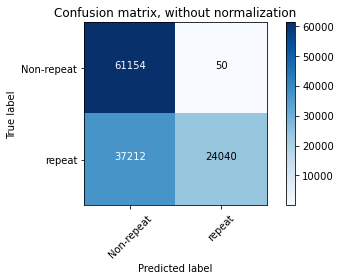

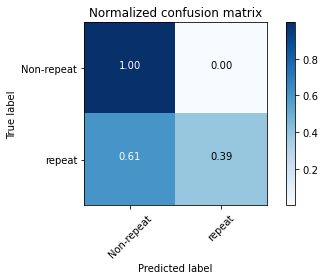

In [253]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
#plt.savefig('figures/XX_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
#plt.savefig('figures/XX_cm_proportion_multi_class.png', bbox_inches="tight")

In [254]:
# from sklearn.model_selection import GridSearchCV
# parameters = {'C':[0.001, 0.1, 1, 10, 100]
#             ''}

# CV = GridSearchCV(logit,parameters)
# CV.fit(X_train, y_train)

# print(CV.best_params_)
# print(CV.best_estimator_)
# print(CV.score(X_test, y_test))

In [255]:
# # Logistic regression model fitting with cross validation
# logit_cv = LogisticRegression(solver='liblinear')
# logit_cv.fit(X, y)
# scores_logit_cv = model_selection.cross_val_score(logit_cv,X,y,cv=5)
# scores_logit_cv.mean()

In [256]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.62      1.00      0.77     61204
           1       1.00      0.39      0.56     61252

    accuracy                           0.70    122456
   macro avg       0.81      0.70      0.66    122456
weighted avg       0.81      0.70      0.66    122456



In [257]:
# plot Precision-Recall curve
average_precision = average_precision_score(y_test, y_pred)
average_precision

0.6955429522523568

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.70')

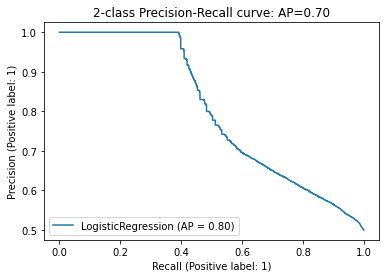

In [258]:
disp = plot_precision_recall_curve(logit, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

In [259]:
# # plot the leaning curve
# from sklearn.model_selection import learning_curve
# train_sizes, train_scores, validation_scores = learning_curve(logit, X, y, train_sizes=np.linspace(0.01, 1.0, 50), cv=3, scoring='accuracy') 

In [260]:
# plt.style.use('seaborn')
# plt.plot(train_sizes, train_scores.mean(axis=1), label = 'Training error')
# plt.plot(train_sizes, validation_scores.mean(axis=1), label = 'Validation error')
# plt.ylabel('MSE', fontsize = 14)
# plt.xlabel('Training set size', fontsize = 14)
# plt.title('Learning curves for a linear regression model', fontsize = 18, y = 1.03)
# plt.legend()
# plt.ylim(0,40)

### 5.2 Decision Tree

In [261]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth=6, random_state=42) 
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
scores_tree_train = tree.score(X_train, y_train)
scores_tree_test = tree.score(X_test, y_test)

print(f'Accuracy on training set: {scores_tree_train}') 
print(f'Accuracy on test set: {scores_tree_test}')

Accuracy on training set: 0.6252449859541386
Accuracy on test set: 0.6243793689161822


In [262]:
from sklearn.tree import export_graphviz
import graphviz

export_graphviz(tree, out_file="tree.dot", class_names=["0","1"], feature_names=X.columns.tolist(), impurity=False, filled=True)

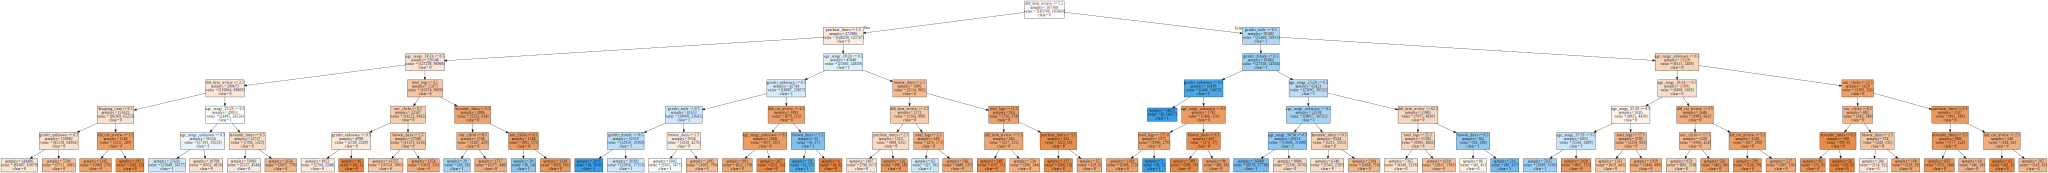

In [263]:
with open("tree.dot") as f: 
    dot_graph = f.read() 
graphviz.Source(dot_graph)

<BarContainer object of 19 artists>

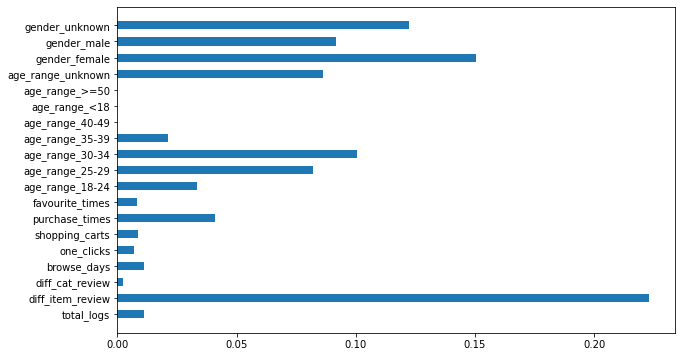

In [264]:
# plot feature importance
fig = plt.figure(figsize=(10,6))
plt.barh(X.columns.tolist(),height=0.5,width=tree.feature_importances_,align="center")

Confusion matrix, without normalization
[[48832 12372]
 [33625 27627]]
Normalized confusion matrix
[[0.8  0.2 ]
 [0.55 0.45]]


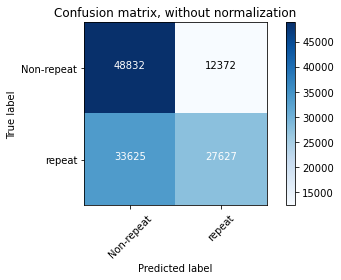

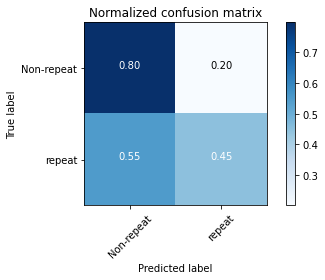

In [265]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
#plt.savefig('figures/XX_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
#plt.savefig('figures/XX_cm_proportion_multi_class.png', bbox_inches="tight")

In [266]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.80      0.68     61204
           1       0.69      0.45      0.55     61252

    accuracy                           0.62    122456
   macro avg       0.64      0.62      0.61    122456
weighted avg       0.64      0.62      0.61    122456



In [267]:
# plot Precision-Recall curve
average_precision = average_precision_score(y_test, y_pred)
average_precision

0.5861171127644493

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.59')

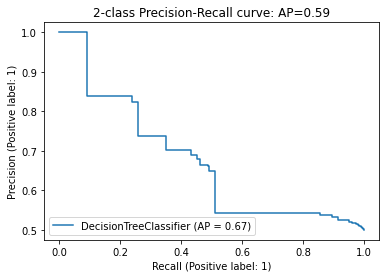

In [268]:
disp = plot_precision_recall_curve(tree, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

### 5.3 Random Forest

In [269]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=100, random_state=42) 
forest.fit(X_train, y_train)
#Predict_proba = forest.predict_proba(X_test)

y_pred = forest.predict(X_test)
scores_forest_train = forest.score(X_train, y_train)
scores_forest_test = forest.score(X_test, y_test)

print(f'Accuracy on training set: {scores_forest_train}') 
print(f'Accuracy on test set: {scores_forest_test}')


Accuracy on training set: 0.7959947518564491
Accuracy on test set: 0.7720814006663618


In [270]:
# from sklearn.ensemble import RandomForestClassifier
# forest = RandomForestClassifier(oob_score=True, n_jobs=-1, n_estimators=1000, max_depth=10, max_features='sqrt', random_state=42) 
# forest.fit(X_train, y_train)
# #Predict_proba = forest.predict_proba(X_test)

# y_pred = forest.predict(X_test)
# scores_forest_train = forest.score(X_train, y_train)
# scores_forest_test = forest.score(X_test, y_test)

# print(f'Accuracy on training set: {scores_forest_train}') 
# print(f'Accuracy on test set: {scores_forest_test}')

<BarContainer object of 19 artists>

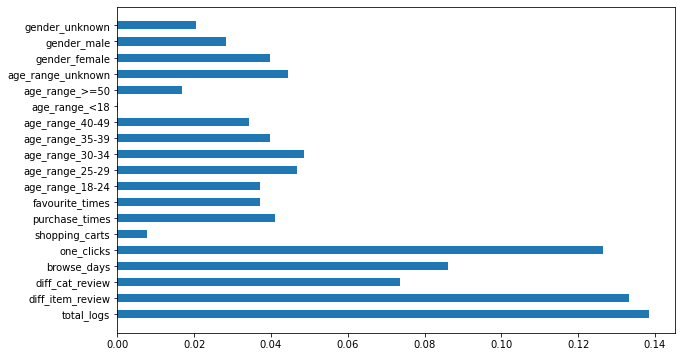

In [271]:
# plot feature importance
fig = plt.figure(figsize=(10,6))
plt.barh(X.columns.tolist(),height=0.5,width=forest.feature_importances_,align="center")

Confusion matrix, without normalization
[[52618  8586]
 [19324 41928]]
Normalized confusion matrix
[[0.86 0.14]
 [0.32 0.68]]


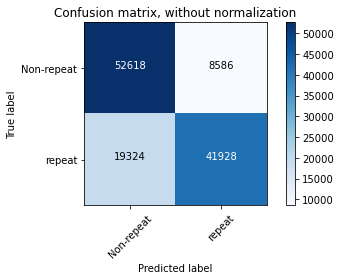

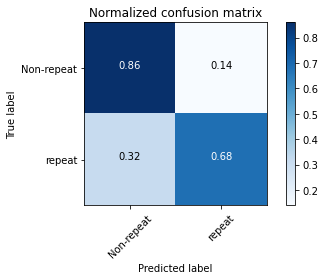

In [272]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
#plt.savefig('figures/XX_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
#plt.savefig('figures/XX_cm_proportion_multi_class.png', bbox_inches="tight")

In [273]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.86      0.79     61204
           1       0.83      0.68      0.75     61252

    accuracy                           0.77    122456
   macro avg       0.78      0.77      0.77    122456
weighted avg       0.78      0.77      0.77    122456



In [274]:
# plot Precision-Recall curve
average_precision = average_precision_score(y_test, y_pred)
average_precision

0.7259709515536253

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.73')

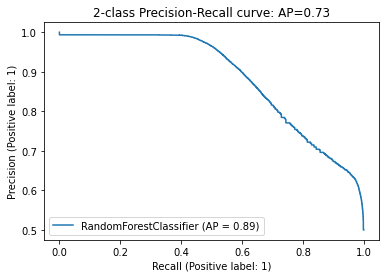

In [275]:
disp = plot_precision_recall_curve(forest, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

### 5.4 Gradient Boosting Tree

In [276]:
from sklearn.ensemble import GradientBoostingClassifier
gbt = GradientBoostingClassifier(random_state=42) 
gbt.fit(X_train, y_train)
#Predict_proba = gbrt.predict_proba(X_test)

y_pred = gbt.predict(X_test)
scores_gbt_train = gbt.score(X_train, y_train)
scores_gbt_test = gbt.score(X_test, y_test)

print(f'Accuracy on training set: {scores_gbt_train}') 
print(f'Accuracy on test set: {scores_gbt_test}')

Accuracy on training set: 0.6723312863395832
Accuracy on test set: 0.6705755536682564


<BarContainer object of 19 artists>

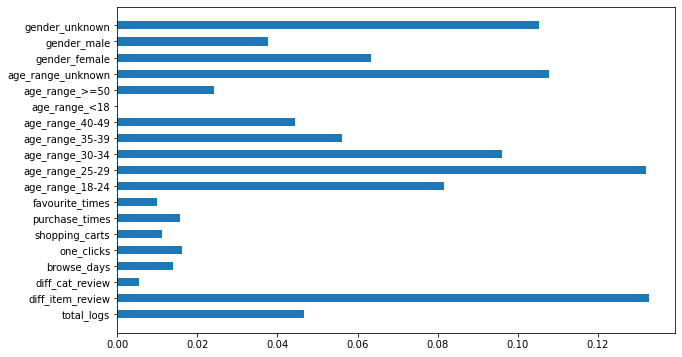

In [277]:
# plot feature importance
fig = plt.figure(figsize=(10,6))
plt.barh(X.columns.tolist(),height=0.5,width=gbt.feature_importances_,align="center")

Confusion matrix, without normalization
[[55668  5536]
 [34804 26448]]
Normalized confusion matrix
[[0.91 0.09]
 [0.57 0.43]]


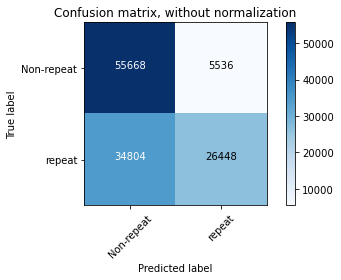

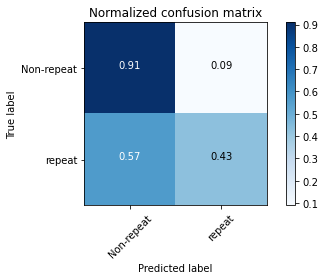

In [278]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
#plt.savefig('figures/XX_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
#plt.savefig('figures/XX_cm_proportion_multi_class.png', bbox_inches="tight")

In [279]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.91      0.73     61204
           1       0.83      0.43      0.57     61252

    accuracy                           0.67    122456
   macro avg       0.72      0.67      0.65    122456
weighted avg       0.72      0.67      0.65    122456



In [280]:
# plot Precision-Recall curve
average_precision = average_precision_score(y_test, y_pred)
average_precision

0.6412693184952336

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.64')

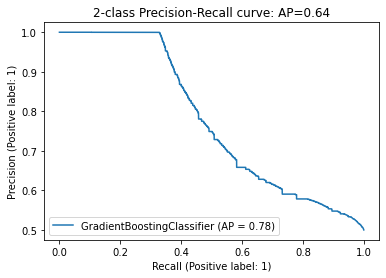

In [281]:
disp = plot_precision_recall_curve(gbt, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

### 5.5 Multilayer Perceptron

In [282]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(solver='adam', activation='relu',alpha=0.1,random_state=42,hidden_layer_sizes=[10,5]).fit(X_train, y_train)
y_pred = mlp.predict(X_test)
#y_pred_proba = mlp.predict_proba(X_test)


score_mlp = accuracy_score(y_test, y_pred)
score_mlp

0.6867936238322336

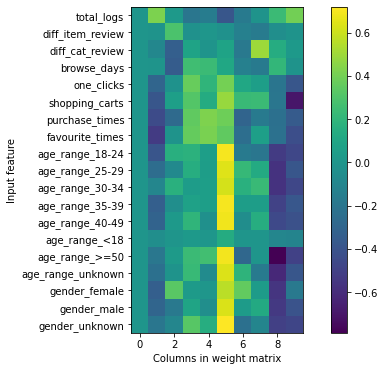

In [283]:
plt.figure(figsize=(10, 6))
plt.imshow(mlp.coefs_[0], interpolation='none')
plt.yticks(range(19), X.columns.tolist()) 
plt.xlabel("Columns in weight matrix") 
plt.ylabel("Input feature") 
plt.colorbar()

Confusion matrix, without normalization
[[51660  9544]
 [28810 32442]]
Normalized confusion matrix
[[0.84 0.16]
 [0.47 0.53]]


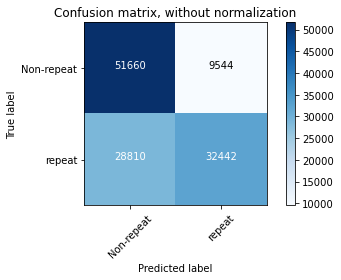

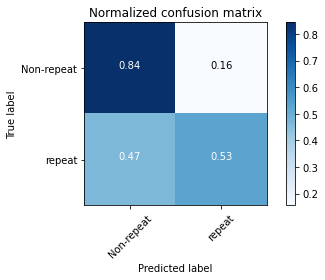

In [284]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
#plt.savefig('figures/XX_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
#plt.savefig('figures/XX_cm_proportion_multi_class.png', bbox_inches="tight")

In [285]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.84      0.73     61204
           1       0.77      0.53      0.63     61252

    accuracy                           0.69    122456
   macro avg       0.71      0.69      0.68    122456
weighted avg       0.71      0.69      0.68    122456



In [286]:
# plot Precision-Recall curve
average_precision = average_precision_score(y_test, y_pred)
average_precision

0.6445198520604075

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.64')

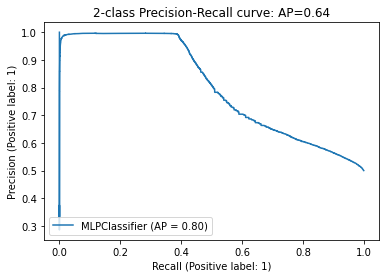

In [287]:
disp = plot_precision_recall_curve(mlp, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

### 5.6 Extreme Gradient Boosting

In [288]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [289]:
import xgboost as xgb

In [290]:
xgbmodel = xgb.XGBClassifier(max_depth=8, use_label_encoder=False, n_estimators=1000, min_child_weight=300, colsample_bytree=0.8, subsample=0.8, eta=0.3, seed=42)

In [291]:
#xgbmodel.fit(X_train, y_train, eval_metric='auc', eval_set=[(X_train, y_train), (X_test, y_test)], verbose=True, early_stopping_rounds=10)

In [292]:
X_train_1 = X_train.copy()
y_train_1 = y_train.copy()
X_test_1 = X_test.copy()
y_test_1 = y_test.copy()

In [293]:
X_train_1.rename(columns={'age_range_<18':'age_range_less18', 'age_range_>=50':'age_range_more50'}, inplace=True)
X_test_1 = X_test_1.rename({'age_range_<18':'age_range_less18', 'age_range_>=50':'age_range_more50'}, inplace=True)

In [294]:
xgbmodel.fit(X_train_1, y_train_1, eval_metric='auc', verbose=True)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, eta=0.3, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=8,
              min_child_weight=300, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=12, num_parallel_tree=1,
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=42, subsample=0.8, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [295]:
y_pred = xgbmodel.predict(X_test)

Confusion matrix, without normalization
[[53682  7522]
 [26064 35188]]
Normalized confusion matrix
[[0.88 0.12]
 [0.43 0.57]]


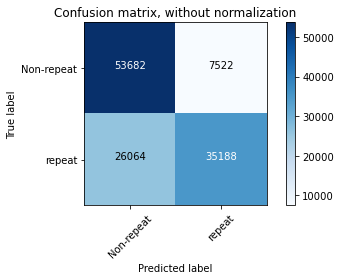

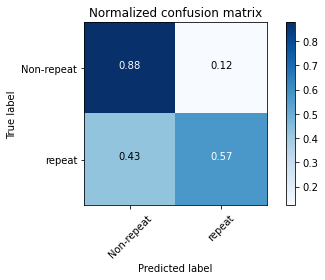

In [296]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
#plt.savefig('figures/XX_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
#plt.savefig('figures/XX_cm_proportion_multi_class.png', bbox_inches="tight")

In [297]:
roc_auc_score(y_test, y_pred)

0.7257893683286011